In [1]:
# the dataset https://www.kaggle.com/datasets/altavish/boston-housing-dataset/data
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('HousingData.csv')
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [3]:
df.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,486.000000,486.000000,486.000000,486.000000,506.000000,506.000000,486.000000,506.000000,506.000000,506.000000,506.000000,506.000000,486.000000,506.000000
mean,3.611874,11.211934,11.083992,0.069959,0.554695,6.284634,68.518519,3.795043,9.549407,408.237154,18.455534,356.674032,12.715432,22.532806
std,8.720192,23.388876,6.835896,0.255340,0.115878,0.702617,27.999513,2.105710,8.707259,168.537116,2.164946,91.294864,7.155871,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.081900,0.000000,5.190000,0.000000,0.449000,5.885500,45.175000,2.100175,4.000000,279.000000,17.400000,375.377500,7.125000,17.025000
50%,0.253715,0.000000,9.690000,0.000000,0.538000,6.208500,76.800000,3.207450,5.000000,330.000000,19.050000,391.440000,11.430000,21.200000
75%,3.560263,12.500000,18.100000,0.000000,0.624000,6.623500,93.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


In [4]:
df = df.dropna()

## No noise, original data

### Regular Linear Regression

In [5]:
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score

In [6]:
N_SPLITS = 5
RESULT_METRICS = {}
kf = KFold(n_splits=N_SPLITS, shuffle=True, random_state=125)

In [7]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1)
    y_train = train["MEDV"]
    X_test = test.drop("MEDV", axis=1)
    y_test = test["MEDV"]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"] = ["Linear Regression"]
RESULT_METRICS["mape"] = [avg_mape]
RESULT_METRICS["mse"] = [avg_mse]
RESULT_METRICS["r2"] = [avg_r2]

Split 0
	MAPE=0.20520163297355312
	MSE=31.129315543299107
	R2=0.6377321944736531

Split 1
	MAPE=0.16298154654969446
	MSE=15.649440542331595
	R2=0.7919567776045002

Split 2
	MAPE=0.18907084200481722
	MSE=18.691613482931864
	R2=0.7752151403661489

Split 3
	MAPE=0.19101510016978424
	MSE=37.68457467753786
	R2=0.5773345103757112

Split 4
	MAPE=0.2191380759571436
	MSE=38.087470104050226
	R2=0.5249673269969963

Average MAPE=0.19348143953099853
Average MSE=28.24848287003013
Average R2=0.661441189963402


### Try robust implementations from sklearn

In [8]:
from sklearn.linear_model import RANSACRegressor, HuberRegressor

In [9]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1)
    y_train = train["MEDV"]
    X_test = test.drop("MEDV", axis=1)
    y_test = test["MEDV"]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = RANSACRegressor(estimator=LinearRegression(fit_intercept=False))
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"].append("RANSAC")
RESULT_METRICS["mape"].append(avg_mape)
RESULT_METRICS["mse"].append(avg_mse)
RESULT_METRICS["r2"].append(avg_r2)

Split 0
	MAPE=0.24914973645452698
	MSE=36.588329783698505
	R2=0.5742028468252668

Split 1
	MAPE=0.2531285236400669
	MSE=48.06578030307392
	R2=0.36101486860463916

Split 2
	MAPE=0.18770974371228746
	MSE=15.571192098247835
	R2=0.8127412471195956

Split 3
	MAPE=0.19063113359906442
	MSE=45.05855449890438
	R2=0.4946288723700565

Split 4
	MAPE=0.5306835373052926
	MSE=214.01762081671166
	R2=-1.6692600534655804

Average MAPE=0.2822605349422477
Average MSE=71.86029550012725
Average R2=0.11466555629079549


In [10]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0
for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1)
    y_train = train["MEDV"]
    X_test = test.drop("MEDV", axis=1)
    y_test = test["MEDV"]
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = HuberRegressor(fit_intercept=False, max_iter=3000)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"].append("Huber Regressor")
RESULT_METRICS["mape"].append(avg_mape)
RESULT_METRICS["mse"].append(avg_mse)
RESULT_METRICS["r2"].append(avg_r2)

Split 0
	MAPE=0.20525133461474537
	MSE=32.81047047500574
	R2=0.6181677325756063

Split 1
	MAPE=0.15141507522638536
	MSE=14.05301365135602
	R2=0.8131796317901812

Split 2
	MAPE=0.17619880313711658
	MSE=16.06763843291702
	R2=0.8067709963568002

Split 3
	MAPE=0.1790242063384169
	MSE=38.639555785692
	R2=0.5666235613703479

Split 4
	MAPE=0.21568265372067166
	MSE=40.32547216294373
	R2=0.4970546276941

Average MAPE=0.18551441460746715
Average MSE=28.379230101582902
Average R2=0.6603593099574072


### Robust Linear Regression

In [11]:
import cvxpy as cp

In [12]:
class RobustLinearRegression:
    def __init__(self, delta):
        self.w = None
        self.delta = delta
        
    def fit(self, X, y):
        lenw = X.shape[1]
        numK = X.shape[0]
        w = cp.Variable(lenw)
        residuals = y - X @ w
        objective = cp.Minimize(cp.sum(cp.square(cp.abs(residuals) + self.delta * cp.norm(w, 2))))
        prob = cp.Problem(objective)
        prob.solve()
        self.w = w.value

    def predict(self, X):
        return X @ self.w

In [13]:
DELTA = 1e-2

avg_mape = 0
avg_mse = 0
avg_r2 = 0

for i, s in enumerate(kf.split(df)):
    train = df.iloc[s[0]]
    test = df.iloc[s[1]]
    X_train = train.drop("MEDV", axis=1).to_numpy()
    y_train = train["MEDV"].to_numpy()
    X_test = test.drop("MEDV", axis=1).to_numpy()
    y_test = test["MEDV"].to_numpy()
    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    lr = RobustLinearRegression(delta=DELTA)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["name"].append("Robust LR")
RESULT_METRICS["mape"].append(avg_mape)
RESULT_METRICS["mse"].append(avg_mse)
RESULT_METRICS["r2"].append(avg_r2)

Split 0
	MAPE=0.20215348152272963
	MSE=30.19938216743002
	R2=0.6485543059618808

Split 1
	MAPE=0.16423354129219264
	MSE=16.12563236083848
	R2=0.7856262969631913

Split 2
	MAPE=0.18830590057009947
	MSE=18.888232183439346
	R2=0.7728506089662608

Split 3
	MAPE=0.18996763022299296
	MSE=37.30106401203158
	R2=0.5816359181692019

Split 4
	MAPE=0.21448194029617737
	MSE=37.586028634793124
	R2=0.5312213806488935

Average MAPE=0.1918284987808384
Average MSE=28.02006787170651
Average R2=0.6639777021418857


Investigate how the value of `delta` influences the regression metrics on the original data

In [14]:
deltas = [1e-7, 1e-6, 1e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
mapes = []
mses = []
r2s = []

for delta in deltas:
    avg_mape = 0
    avg_mse = 0
    avg_r2 = 0
    for i, s in enumerate(kf.split(df)):
        train = df.iloc[s[0]]
        test = df.iloc[s[1]]
        X_train = train.drop("MEDV", axis=1).to_numpy()
        y_train = train["MEDV"].to_numpy()
        X_test = test.drop("MEDV", axis=1).to_numpy()
        y_test = test["MEDV"].to_numpy()
        scaler = MinMaxScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        lr = RobustLinearRegression(delta=delta)
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        avg_mape += mean_absolute_percentage_error(y_test, y_pred)
        avg_mse += mean_squared_error(y_test, y_pred)
        avg_r2 += r2_score(y_test, y_pred)
    mapes.append(avg_mape / N_SPLITS)
    mses.append(avg_mse / N_SPLITS)
    r2s.append(avg_r2 / N_SPLITS)

c:\Users\amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\amina\AppData\Local\Programs\Python\Python311\Lib\site-packages\cvxpy\problems\problem.py:1407: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with 

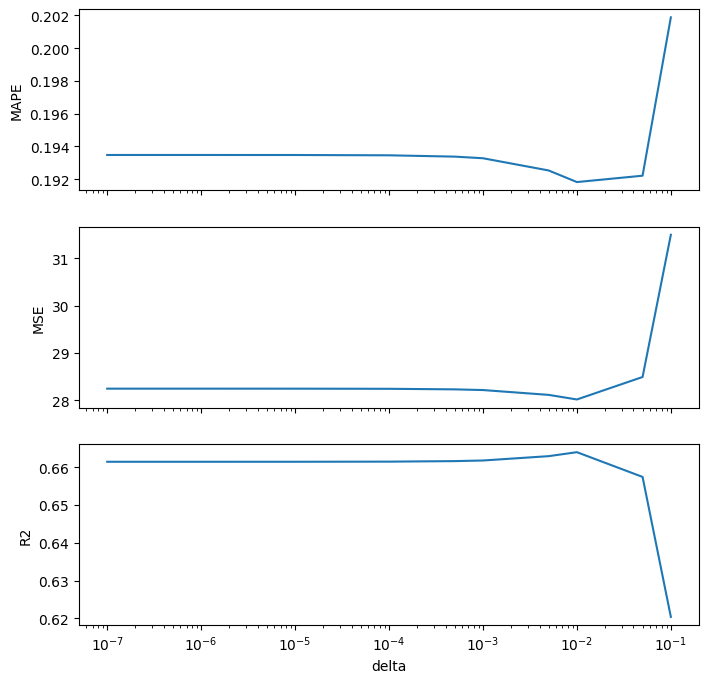

In [15]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 8))
ax[0].plot(deltas, mapes)
ax[1].plot(deltas, mses)
ax[2].plot(deltas, r2s)
ax[0].set_ylabel('MAPE')
ax[1].set_ylabel('MSE')
ax[2].set_ylabel('R2')
plt.xlabel('delta')
plt.xscale('log')
plt.show()

### Compare different models

In [16]:
results = pd.DataFrame(RESULT_METRICS)
results

,name,mape,mse,r2
0,Linear Regression,0.193481,28.248483,0.661441
1,RANSAC,0.282261,71.860296,0.114666
2,Huber Regressor,0.185514,28.379230,0.660359
3,Robust LR,0.191828,28.020068,0.663978


## Add noise to the data

In [17]:
np.random.seed(125)

y = df["MEDV"].to_numpy()
X = df.drop("MEDV", axis=1).to_numpy()

NOISE_DELTA = 0.1
N = np.random.normal(0, 1, X.shape)
row_norms = np.linalg.norm(N, axis=1, keepdims=True)
N = np.diag(np.reciprocal(row_norms.ravel())) @ N
X_noised = X + N * NOISE_DELTA * (X.max(axis=0) - X.min(axis=0))

In [18]:
avg_mape = 0
avg_mse = 0
avg_r2 = 0

for i, s in enumerate(kf.split(df)):
    X_train = X_noised[s[0]]
    y_train = y[s[0]]
    X_test = X_noised[s[1]]
    y_test = y[s[1]]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # N = np.random.normal(0, 1, X_train.shape)
    # row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
    # D = np.diag (np.reciprocal(row_norms).ravel())
    # N = np.matmul(D, N)
    # X_train_noised = X_train + N * NOISE_DELTA * (X_train.max(axis=0) - X_train.min(axis=0))
    
    lr = LinearRegression(fit_intercept=False)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

RESULT_METRICS["noisy_mape"] = [avg_mape]
RESULT_METRICS["noisy_mse"] = [avg_mse]
RESULT_METRICS["noisy_r2"] = [avg_r2]

Split 0
	MAPE=0.1961824430945418
	MSE=30.87436829697178
	R2=0.6406991462951128

Split 1
	MAPE=0.1717620299416979
	MSE=17.208144918449705
	R2=0.7712354054703073

Split 2
	MAPE=0.22368730385074592
	MSE=25.186462689674947
	R2=0.6971082520221377

Split 3
	MAPE=0.20332132416138596
	MSE=39.95239933090955
	R2=0.5518988719029034

Split 4
	MAPE=0.2270154601780129
	MSE=39.43531617073976
	R2=0.5081567875175568

Average MAPE=0.2043937122452769
Average MSE=30.531338281349143
Average R2=0.6338196926416035


In [19]:
DELTA = 1e-2

avg_mape = 0
avg_mse = 0
avg_r2 = 0

for i, s in enumerate(kf.split(df)):
    X_train = X_noised[s[0]]
    y_train = y[s[0]]
    X_test = X_noised[s[1]]
    y_test = y[s[1]]

    scaler = MinMaxScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # N = np.random.normal(0, 1, X_train.shape)
    # row_norms = np.linalg.norm(N, ord=2, axis=1, keepdims=True)
    # D = np.diag (np.reciprocal(row_norms).ravel())
    # N = np.matmul(D, N)
    # X_train_noised = X_train + NOISE_DELTA * N
    lr = RobustLinearRegression(delta=DELTA)
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    print(f'Split {i}')
    print(f'\tMAPE={mean_absolute_percentage_error(y_test, y_pred)}')
    print(f'\tMSE={mean_squared_error(y_test, y_pred)}')
    print(f'\tR2={r2_score(y_test, y_pred)}')
    print()
    avg_mape += mean_absolute_percentage_error(y_test, y_pred)
    avg_mse += mean_squared_error(y_test, y_pred)
    avg_r2 += r2_score(y_test, y_pred)
avg_mape /= N_SPLITS
avg_mse /= N_SPLITS
avg_r2 /= N_SPLITS

print(f'Average MAPE={avg_mape}')
print(f'Average MSE={avg_mse}')
print(f'Average R2={avg_r2}')

Split 0
	MAPE=0.19373913045326277
	MSE=30.046323793393082
	R2=0.6503355247362759

Split 1
	MAPE=0.17229846513857586
	MSE=17.68337153662159
	R2=0.7649177561751035

Split 2
	MAPE=0.22157871425857933
	MSE=25.154372912326124
	R2=0.6974941628534109

Split 3
	MAPE=0.20205045829098406
	MSE=39.485091240827764
	R2=0.5571401411593544

Split 4
	MAPE=0.2236630849326196
	MSE=38.637457160194856
	R2=0.5181078054618642

Average MAPE=0.20266597061480432
Average MSE=30.20132332867268
Average R2=0.6375990780772017
